In [1]:
import time
startTime=time.time()

from tensorflow.keras.models import load_model
model_01 = load_model('.\\checkpoint\\checkpoint099.ckpt')  
model_01.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,194,561
Trainable params: 4,194,561
Non-trainable params: 0
_________________________________________________________________


In [2]:
#获取原模型的层，含层构造、权重参数。
newDense01=model_01.get_layer('dense_12') 
print('newDense01=',newDense01)
dropout01=model_01.get_layer('dropout_6')
print('dropout01=',dropout01)
newDense02=model_01.get_layer('dense_13')
print('newDense02=',newDense02)

newDense01= <keras.layers.core.dense.Dense object at 0x000002D6B43C7EB0>
dropout01= <keras.layers.regularization.dropout.Dropout object at 0x000002D6B4410610>
newDense02= <keras.layers.core.dense.Dense object at 0x000002D6B4410790>


In [3]:
#重建模型
input_shape=(256, 256, 3)
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                    include_top= False, # When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).
                    input_shape=input_shape,
                    )
conv_base.summary()

from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) 
model.add(newDense01) #含构造、权重参数。
#model.add(dropout01)  #dropout层不含权重参数，所以自己新建也行
model.add(newDense02)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [4]:
#conv_base.trainable = False

conv_base.trainable = True #我没有冻结过，所以不要这句也行
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               4194432   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 18,909,249
Trainable params: 8,914,177
Non-trainable params: 9,995,072
_________________________________________________________________


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir='.\\dataset\\train'
validation_dir='.\\dataset\\validation'
test_dir='.\\dataset\\test'
extra_test_dir='.\\dataset\\extra_test'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
extra_test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 54 #查看显卡信息：nvidia-smi
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(input_shape[0], input_shape[1]),
                                                    batch_size=batch_size,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
                                                        validation_dir,
                                                        target_size=(input_shape[0], input_shape[1]),
                                                        batch_size=batch_size,
                                                        class_mode='binary')


Found 8748 images belonging to 2 classes.
Found 4374 images belonging to 2 classes.


In [7]:
from tensorflow.keras import optimizers
import tensorflow
model.compile(optimizer=optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['acc'])

callbacks_list = [tensorflow.keras.callbacks.ModelCheckpoint(filepath="./checkpoint/checkpoint{epoch:03d}.ckpt")]
history = model.fit(
                                train_generator,
                                #steps_per_epoch=200,
                                epochs=50,
                                callbacks=callbacks_list,
                                validation_data=validation_generator,
                                #validation_steps=100,
                                )
model.save('pretrained network fine-tuning.h5')

Epoch 1/50
162/162 [==============================] - ETA: 0s - loss: 3.3526 - acc: 0.6574

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint001.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint001.ckpt\assets


162/162 [==============================] - 56s 304ms/step - loss: 3.3526 - acc: 0.6574 - val_loss: 0.5085 - val_acc: 0.7588
Epoch 2/50
162/162 [==============================] - ETA: 0s - loss: 0.3740 - acc: 0.8232

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint002.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint002.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 0.3740 - acc: 0.8232 - val_loss: 0.2560 - val_acc: 0.8873
Epoch 3/50
162/162 [==============================] - ETA: 0s - loss: 0.1744 - acc: 0.9278

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint003.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint003.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.1744 - acc: 0.9278 - val_loss: 0.1705 - val_acc: 0.9300
Epoch 4/50
162/162 [==============================] - ETA: 0s - loss: 0.0818 - acc: 0.9686

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint004.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint004.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.0818 - acc: 0.9686 - val_loss: 0.0387 - val_acc: 0.9899
Epoch 5/50
162/162 [==============================] - ETA: 0s - loss: 0.0631 - acc: 0.9767

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint005.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint005.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 0.0631 - acc: 0.9767 - val_loss: 0.0223 - val_acc: 0.9952
Epoch 6/50
162/162 [==============================] - ETA: 0s - loss: 0.0244 - acc: 0.9917

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint006.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint006.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.0244 - acc: 0.9917 - val_loss: 0.0109 - val_acc: 0.9970
Epoch 7/50
162/162 [==============================] - ETA: 0s - loss: 0.0089 - acc: 0.9982

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint007.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint007.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.0089 - acc: 0.9982 - val_loss: 0.0052 - val_acc: 0.9993
Epoch 8/50
162/162 [==============================] - ETA: 0s - loss: 0.0172 - acc: 0.9944

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint008.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint008.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9991
Epoch 9/50
162/162 [==============================] - ETA: 0s - loss: 0.0048 - acc: 0.9992

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint009.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint009.ckpt\assets


162/162 [==============================] - 48s 298ms/step - loss: 0.0048 - acc: 0.9992 - val_loss: 0.0206 - val_acc: 0.9934
Epoch 10/50
162/162 [==============================] - ETA: 0s - loss: 0.0017 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint010.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint010.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9995
Epoch 11/50
162/162 [==============================] - ETA: 0s - loss: 7.5801e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint011.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint011.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 7.5801e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 12/50
162/162 [==============================] - ETA: 0s - loss: 6.0931e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint012.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint012.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 6.0931e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9998
Epoch 13/50
162/162 [==============================] - ETA: 0s - loss: 4.7186e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint013.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint013.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 4.7186e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 0.9998
Epoch 14/50
162/162 [==============================] - ETA: 0s - loss: 4.5144e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint014.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint014.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 4.5144e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9998
Epoch 15/50
162/162 [==============================] - ETA: 0s - loss: 3.3688e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint015.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint015.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 3.3688e-04 - acc: 1.0000 - val_loss: 9.4442e-04 - val_acc: 0.9998
Epoch 16/50
162/162 [==============================] - ETA: 0s - loss: 2.2596e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint016.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint016.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 2.2596e-04 - acc: 1.0000 - val_loss: 8.8883e-04 - val_acc: 0.9998
Epoch 17/50
162/162 [==============================] - ETA: 0s - loss: 1.5945e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint017.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint017.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 1.5945e-04 - acc: 1.0000 - val_loss: 8.3007e-04 - val_acc: 1.0000
Epoch 18/50
162/162 [==============================] - ETA: 0s - loss: 1.4106e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint018.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint018.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 1.4106e-04 - acc: 1.0000 - val_loss: 7.1796e-04 - val_acc: 0.9998
Epoch 19/50
162/162 [==============================] - ETA: 0s - loss: 1.6857e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint019.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint019.ckpt\assets


162/162 [==============================] - 49s 301ms/step - loss: 1.6857e-04 - acc: 1.0000 - val_loss: 7.4543e-04 - val_acc: 1.0000
Epoch 20/50
162/162 [==============================] - ETA: 0s - loss: 1.1593e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint020.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint020.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 1.1593e-04 - acc: 1.0000 - val_loss: 6.3327e-04 - val_acc: 1.0000
Epoch 21/50
162/162 [==============================] - ETA: 0s - loss: 1.0112e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint021.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint021.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 1.0112e-04 - acc: 1.0000 - val_loss: 5.9069e-04 - val_acc: 0.9998
Epoch 22/50
162/162 [==============================] - ETA: 0s - loss: 8.4954e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint022.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint022.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 8.4954e-05 - acc: 1.0000 - val_loss: 4.2170e-04 - val_acc: 1.0000
Epoch 23/50
162/162 [==============================] - ETA: 0s - loss: 1.0511e-04 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint023.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint023.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 1.0511e-04 - acc: 1.0000 - val_loss: 5.4863e-04 - val_acc: 0.9998
Epoch 24/50
162/162 [==============================] - ETA: 0s - loss: 9.0316e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint024.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint024.ckpt\assets


162/162 [==============================] - 48s 298ms/step - loss: 9.0316e-05 - acc: 1.0000 - val_loss: 5.6284e-04 - val_acc: 0.9998
Epoch 25/50
162/162 [==============================] - ETA: 0s - loss: 5.2942e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint025.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint025.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 5.2942e-05 - acc: 1.0000 - val_loss: 3.6898e-04 - val_acc: 1.0000
Epoch 26/50
162/162 [==============================] - ETA: 0s - loss: 4.5366e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint026.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint026.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 4.5366e-05 - acc: 1.0000 - val_loss: 5.1218e-04 - val_acc: 0.9998
Epoch 27/50
162/162 [==============================] - ETA: 0s - loss: 4.5007e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint027.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint027.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 4.5007e-05 - acc: 1.0000 - val_loss: 4.0164e-04 - val_acc: 1.0000
Epoch 28/50
162/162 [==============================] - ETA: 0s - loss: 3.6274e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint028.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint028.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 3.6274e-05 - acc: 1.0000 - val_loss: 3.8171e-04 - val_acc: 0.9998
Epoch 29/50
162/162 [==============================] - ETA: 0s - loss: 3.0089e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint029.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint029.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 3.0089e-05 - acc: 1.0000 - val_loss: 3.2570e-04 - val_acc: 0.9998
Epoch 30/50
162/162 [==============================] - ETA: 0s - loss: 2.8072e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint030.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint030.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 2.8072e-05 - acc: 1.0000 - val_loss: 3.4647e-04 - val_acc: 0.9998
Epoch 31/50
162/162 [==============================] - ETA: 0s - loss: 3.1366e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint031.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint031.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 3.1366e-05 - acc: 1.0000 - val_loss: 3.5997e-04 - val_acc: 0.9998
Epoch 32/50
162/162 [==============================] - ETA: 0s - loss: 2.2554e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint032.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint032.ckpt\assets


162/162 [==============================] - 49s 301ms/step - loss: 2.2554e-05 - acc: 1.0000 - val_loss: 2.7535e-04 - val_acc: 1.0000
Epoch 33/50
162/162 [==============================] - ETA: 0s - loss: 2.0581e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint033.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint033.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 2.0581e-05 - acc: 1.0000 - val_loss: 2.8652e-04 - val_acc: 0.9998
Epoch 34/50
162/162 [==============================] - ETA: 0s - loss: 1.9065e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint034.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint034.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 1.9065e-05 - acc: 1.0000 - val_loss: 2.4466e-04 - val_acc: 1.0000
Epoch 35/50
162/162 [==============================] - ETA: 0s - loss: 1.7476e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint035.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint035.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 1.7476e-05 - acc: 1.0000 - val_loss: 3.3376e-04 - val_acc: 0.9998
Epoch 36/50
162/162 [==============================] - ETA: 0s - loss: 1.5970e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint036.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint036.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 1.5970e-05 - acc: 1.0000 - val_loss: 2.5570e-04 - val_acc: 1.0000
Epoch 37/50
162/162 [==============================] - ETA: 0s - loss: 1.3005e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint037.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint037.ckpt\assets


162/162 [==============================] - 49s 301ms/step - loss: 1.3005e-05 - acc: 1.0000 - val_loss: 3.7079e-04 - val_acc: 0.9998
Epoch 38/50
162/162 [==============================] - ETA: 0s - loss: 1.2368e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint038.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint038.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 1.2368e-05 - acc: 1.0000 - val_loss: 3.6976e-04 - val_acc: 0.9998
Epoch 39/50
162/162 [==============================] - ETA: 0s - loss: 1.1469e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint039.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint039.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 1.1469e-05 - acc: 1.0000 - val_loss: 2.2612e-04 - val_acc: 1.0000
Epoch 40/50
162/162 [==============================] - ETA: 0s - loss: 1.0186e-05 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint040.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint040.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 1.0186e-05 - acc: 1.0000 - val_loss: 2.6718e-04 - val_acc: 0.9998
Epoch 41/50
162/162 [==============================] - ETA: 0s - loss: 8.8893e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint041.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint041.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 8.8893e-06 - acc: 1.0000 - val_loss: 2.0893e-04 - val_acc: 1.0000
Epoch 42/50
162/162 [==============================] - ETA: 0s - loss: 8.2402e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint042.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint042.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 8.2402e-06 - acc: 1.0000 - val_loss: 2.5879e-04 - val_acc: 0.9998
Epoch 43/50
162/162 [==============================] - ETA: 0s - loss: 7.0323e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint043.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint043.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 7.0323e-06 - acc: 1.0000 - val_loss: 1.8927e-04 - val_acc: 1.0000
Epoch 44/50
162/162 [==============================] - ETA: 0s - loss: 7.0107e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint044.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint044.ckpt\assets


162/162 [==============================] - 49s 298ms/step - loss: 7.0107e-06 - acc: 1.0000 - val_loss: 2.1652e-04 - val_acc: 1.0000
Epoch 45/50
162/162 [==============================] - ETA: 0s - loss: 6.2674e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint045.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint045.ckpt\assets


162/162 [==============================] - 49s 300ms/step - loss: 6.2674e-06 - acc: 1.0000 - val_loss: 1.7928e-04 - val_acc: 1.0000
Epoch 46/50
162/162 [==============================] - ETA: 0s - loss: 5.5017e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint046.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint046.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 5.5017e-06 - acc: 1.0000 - val_loss: 3.2466e-04 - val_acc: 0.9998
Epoch 47/50
162/162 [==============================] - ETA: 0s - loss: 4.7757e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint047.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint047.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 4.7757e-06 - acc: 1.0000 - val_loss: 1.9217e-04 - val_acc: 1.0000
Epoch 48/50
162/162 [==============================] - ETA: 0s - loss: 4.1585e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint048.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint048.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 4.1585e-06 - acc: 1.0000 - val_loss: 1.4938e-04 - val_acc: 1.0000
Epoch 49/50
162/162 [==============================] - ETA: 0s - loss: 3.7872e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint049.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint049.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 3.7872e-06 - acc: 1.0000 - val_loss: 2.0527e-04 - val_acc: 0.9998
Epoch 50/50
162/162 [==============================] - ETA: 0s - loss: 3.6458e-06 - acc: 1.0000

INFO:tensorflow:Assets written to: ./checkpoint\checkpoint050.ckpt\assets


INFO:tensorflow:Assets written to: ./checkpoint\checkpoint050.ckpt\assets


162/162 [==============================] - 49s 299ms/step - loss: 3.6458e-06 - acc: 1.0000 - val_loss: 1.3887e-04 - val_acc: 1.0000


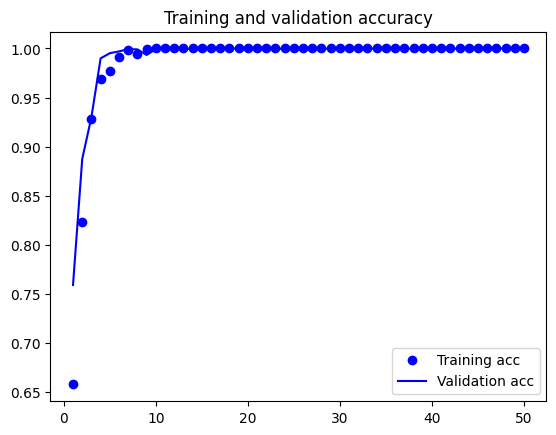

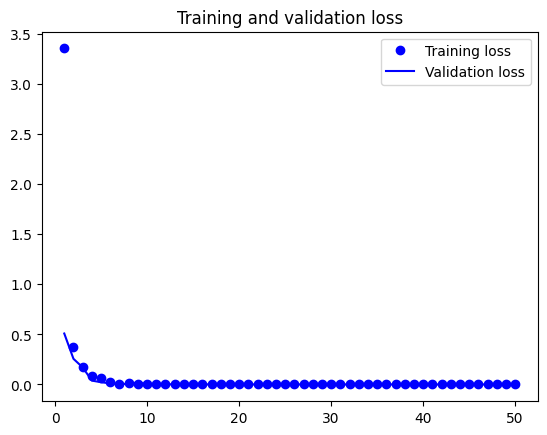

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
test_generator = test_datagen.flow_from_directory(
                                                        test_dir,
                                                        target_size=(input_shape[0], input_shape[1]),
                                                        batch_size=batch_size,
                                                        class_mode='binary')
extra_generator = extra_test_datagen.flow_from_directory(
                                                        extra_test_dir,
                                                        target_size=(input_shape[0], input_shape[1]),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 4374 images belonging to 2 classes.
Found 7290 images belonging to 2 classes.


In [16]:
model= load_model('.\\checkpoint\\checkpoint045.ckpt')  
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               4194432   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 18,909,249
Trainable params: 8,914,177
Non-trainable params: 9,995,072
_________________________________________________________________


In [17]:
train_loss, train_acc = model.evaluate(train_generator)
print('train_acc=',train_acc)

validation_loss, validation_acc = model.evaluate(validation_generator)
print('validation_acc=',validation_acc)

test_loss, test_acc = model.evaluate(test_generator)
print('test_acc=',test_acc)

extra_loss, extra_acc = model.evaluate(extra_generator)
print('extra_acc=',extra_acc)

162/162 [==============================] - 29s 174ms/step - loss: 8.6049e-06 - acc: 1.0000
train_acc= 1.0
81/81 [==============================] - 14s 174ms/step - loss: 1.7928e-04 - acc: 1.0000
validation_acc= 1.0
81/81 [==============================] - 14s 174ms/step - loss: 2.0394e-04 - acc: 1.0000
test_acc= 1.0
135/135 [==============================] - 24s 175ms/step - loss: 1.0157 - acc: 0.8918
extra_acc= 0.891769528388977
